In [65]:
import pyisopach
import matplotlib.pyplot as plt
from pyteomics import mass
import numpy as np
import pandas as pd
import re
import mss
from scipy import special

In [2]:
mol = pyisopach.Molecule('C18H23N2O2')

In [3]:
mol.isotopic_distribution()[0][0]

299.1765013928997

<BarContainer object of 4 artists>

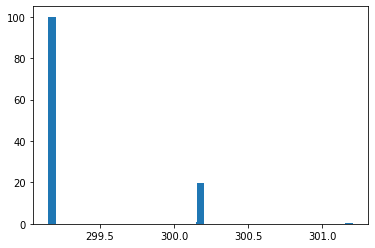

In [4]:
plt.bar(mol.isotopic_distribution()[0], mol.isotopic_distribution()[1], width=0.05)

In [5]:
cfg = pd.read_csv('./cfg/100-500.csv',index_col=0)

In [86]:
def formula_calc(mz, composition, error=5, mode='pos'):
    e_weight = 0.0005485799
    if mode == 'pos':
        mz = mz + e_weight
    elif mode == 'neg':
        mz = mz - e_weight
    
    low_mz = mz - mz * error * 1e-6
    high_mz = mz + mz * error * 1e-6
    
    hit = cfg[(cfg['Mass'] >= low_mz) & (cfg['Mass'] <= high_mz)].copy()
    hit['M.Mass'] = mz
    hit['error in Da'] = mz - hit['Mass']
    hit['error in ppm'] = hit['error in Da'] / mz * 1e6
    
    hit = hit.iloc[hit['error in ppm'].abs().argsort()]
    
    for i in hit.index:
        f_reg = re.findall(r'([A-Z][a-z]*)', i)
        ip_reg = re.findall(r'([A-Z][a-z]*)', composition)
        if len([i for i in f_reg if i not in ip_reg]) > 0:
            hit.drop(i,inplace=True)
    
    return hit

In [152]:
formula_calc(299.1765,'CHON')

,Mass,M.Mass,error in Da,error in ppm
C6H27O9N4,299.17764,299.177049,-0.000591,-1.976823
C18H23O2N2,299.17586,299.177049,0.001189,3.972831


In [8]:
path = 's1.mzML'
scans = mss.mssmain.get_scans(path, ms_all=False, ms_lv=1)
#noise removal
mss.mssmain.noise_removal(scans, 5000)

In [9]:
def ms_chromatogram_list(mzml_scans, input_mz, error):
    '''
    Generate a peak list for specific input_mz over
    whole rt period from the mzml file
    ***Most useful function!
    '''

    # Create empty list to store the data
    retention_time = []
    intensity = []
    for scan in mzml_scans:
        # print(i)
        retention_time.append(scan.scan_time[0])

        target_mz, target_index = mss.mssmain.mz_locator(scan.mz, input_mz, error)
        if len(target_index) == 0:
            intensity.append(0)
        else:
            # intensity.append(scan.i[target_index])
            # if select_app=True
            intensity.append(sum(scan.i[target_index]))

    return retention_time, intensity

In [10]:
def iso_plot(mzml_scan, input_mz, error, formula):
    '''
    Interactive spectrum plot with nearest retention time from the given scan
    mzml_scans: mzfile
    time: selected time for the scan
    '''
    def ms_chromatogram_list(mzml_scans, input_mz, error):
        '''
        Generate a peak list for specific input_mz over
        whole rt period from the mzml file
        ***Most useful function!
        '''

        # Create empty list to store the data
        retention_time = []
        intensity = []
        for scan in mzml_scans:
            # print(i)
            retention_time.append(scan.scan_time[0])

            target_mz, target_index = mss.mssmain.mz_locator(scan.mz, input_mz, error) #remove the mss.mssmain prefix here when intergrate
            if len(target_index) == 0:
                intensity.append(0)
            else:
                # intensity.append(scan.i[target_index])
                # if select_app=True
                intensity.append(sum(scan.i[target_index]))

        return retention_time, intensity
    
    def closest(lst, K): 
        idx = np.abs(np.asarray(lst) - K).argmin()
        return idx
    
    scan = mzml_scan[np.argmax(ms_chromatogram_list(mzml_scan, input_mz, error)[1])]
    
    mz = scan.mz
    ints = scan.i
    rt = scan.scan_time[0]
    
    precursor_idx = closest(mz, input_mz)
    precursor_mz = mz[precursor_idx]
    precursor_ints = ints[precursor_idx]
    
    rel_abundance = [i / precursor_ints * 100 for i in ints]
    
    #Predicted isotope pattern
    mol = pyisopach.Molecule(formula)
    isotope_i = [-i for i in mol.isotopic_distribution()[1]]
    
    
    wd = 0.05
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.bar(mz, rel_abundance, width=wd, label='scan spectrum')
    ax.bar(mol.isotopic_distribution()[0], isotope_i, width=wd, label='predicted isotope pattern')
    ax.axhline(y=0, color='k')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ticks = ax.get_yticks()
    ax.set_yticklabels([int(abs(tick)) for tick in ticks])
    plt.xlabel('m/z')
    plt.ylabel('Relative Intensity %')
    plt.title('Isotope pattern comparison')
    plt.legend()
    plt.xlim(precursor_mz - 5, precursor_mz + 10)

    return


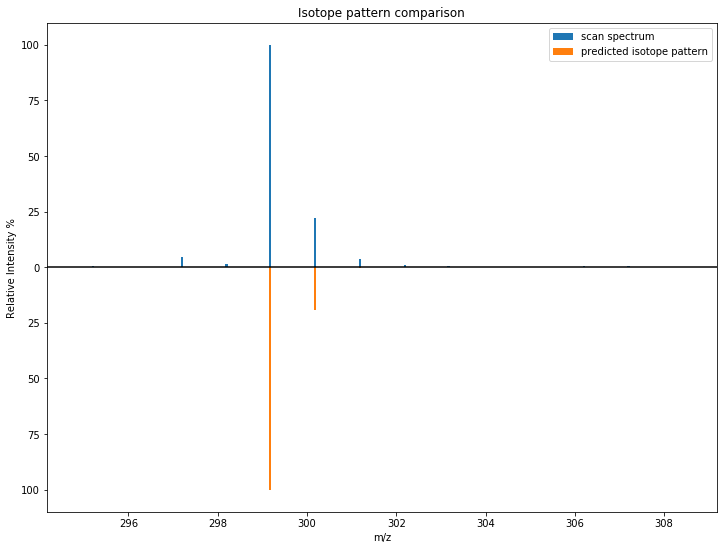

In [11]:
iso_plot(scans,299.1765,5,'C18H23N2O2')

In [221]:
def formula_prediction(mzml_scan, input_mz, error, composition = 'CHON', f_error=5, mode='pos', relintensity_thres = 1):
    '''
    Interactive spectrum plot with nearest retention time from the given scan
    mzml_scans: mzfile
    time: selected time for the scan
    '''
    def ms_chromatogram_list(mzml_scans, input_mz, error):
        '''
        Generate a peak list for specific input_mz over
        whole rt period from the mzml file
        ***Most useful function!
        '''

        # Create empty list to store the data
        retention_time = []
        intensity = []
        for scan in mzml_scans:
            # print(i)
            retention_time.append(scan.scan_time[0])

            target_mz, target_index = mss.mssmain.mz_locator(scan.mz, input_mz, error) #remove the mss.mssmain prefix here when intergrate
            if len(target_index) == 0:
                intensity.append(0)
            else:
                # intensity.append(scan.i[target_index])
                # if select_app=True
                intensity.append(sum(scan.i[target_index]))

        return retention_time, intensity
    
    def closest(lst, K): 
        idx = np.abs(np.asarray(lst) - K).argmin()
        return idx
    
    scan = mzml_scan[np.argmax(ms_chromatogram_list(mzml_scan, input_mz, error)[1])]
    
    mz = scan.mz
    ints = scan.i
    
    precursor_idx = closest(mz, input_mz)
    precursor_mz = mz[precursor_idx]
    precursor_ints = ints[precursor_idx]
    
    rel_abundance = [i / precursor_ints * 100 for i in ints]
    
    prediction_table = formula_calc(precursor_mz, composition, error=f_error, mode='pos')
    
    #Find closest pair
    measured_spec = list(zip(mz, rel_abundance))
    
    def alpha(f):
        if f >= 80:
            alpha = 1
        elif 20 <= f < 80:
            alpha = -0.0033 * f + 1.2667
        elif 10 <= f < 20:
            alpha = -0.08 * f + 2.8
        elif 5 <= f < 10:
            alpha = -0.1 * f + 3
        elif 1<= f < 5:
            alpha = -1.875 * f + 11.875
        return alpha

    def beta(f):
        if f >= 80:
            beta = 0.06
        elif 1 <= f < 80:
            beta = 2.0437 * (f ** 0.765)
        return beta

    for formula in prediction_table.index:
        mol = pyisopach.Molecule(formula)
        istp_mass = mol.isotopic_distribution()[0]
        istp_ints = mol.isotopic_distribution()[1]
        idx = np.argwhere(istp_ints >= intensity_thres).reshape(1, -1)[0]
        #Ref SIRUIS 2013 paper
        m_list = istp_mass[idx]
        f_list = istp_ints[idx]

        theo_spec = list(zip(m_list, f_list))
            
        dist = lambda x, y: (x[0]-y[0])**2 + (x[1]-y[1])**2
        score = []
        for p in theo_spec:
        
            measured_peak = [i for i in measured_spec if i[0] >= p[0]*(1-1e-6*7) 
                             and i[0] <= p[0]*(1+1e-6*7)]
            if len(measured_peak) != 0:
                hit_peak = min(measured_peak, key=lambda peak: dist(peak, p))
                
                # Function from SIRIUS, may need later validation
                f = hit_peak[1]
                sigma_m = np.sqrt(2) * hit_peak[0] * 1/3 * 1e-6 * 7 * alpha(f)
                x = abs(hit_peak[0] - p[0]) / sigma_m
                P_Mm = special.erfc(x)
                
                sigma_f = np.sqrt(2) * 1/3 * hit_peak[1] * np.log10(1 + beta(f))
                y = np.log10(hit_peak[1] / p[1]) / sigma_f
                P_fp = special.erfc(y)
                
                score.append(0.5 * (P_Mm + P_fp))
                
            else:
                hit_peak = []
                score.append(0)
        prediction_table.loc[formula, 'score'] = np.mean(score) * 100
    
    prediction_table.sort_values(by=['score'], inplace=True, ascending=False)
    
    return prediction_table

In [223]:
formula_prediction(scans, 299.1765, 5, f_error=10)

,Mass,M.Mass,error in Da,error in ppm,score
C18H23O2N2,299.17586,299.177601,0.001741,5.819185,73.208437
C6H27O9N4,299.17764,299.177601,-0.000039,-0.130458,43.004197
C16H21ON5,299.17462,299.177601,0.002981,9.963880,33.682879
C8H29O10N,299.17888,299.177601,-0.001279,-4.275154,27.183590
C9H25O6N5,299.18040,299.177601,-0.002799,-9.355748,18.528898
C7H23O5N8,299.17916,299.177601,-0.001559,-5.211053,17.787027
C23H23,299.17986,299.177601,-0.002259,-7.550800,0.000000
